In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [2]:
%%time
data = pd.DataFrame()
for i in range(2010, 2019):
    tmp = pd.read_csv(f'../input/mlbplaybyplay2010s/all{i}.csv')
    tmp['YEAR'] = i
    data = data.append(tmp)
data = data.reset_index(drop=True)

CPU times: user 6min 56s, sys: 32.2 s, total: 7min 28s
Wall time: 1min 16s


In [3]:
single, double, triple, homerun = 20, 21, 22, 23
bb_hbp = [14, 15, 16]
strikeout = 3

In [4]:
bat_event_counts = data.groupby(['BAT_ID', 'YEAR'])['EVENT_CD'].value_counts()
pit_event_counts = data.groupby(['PIT_ID', 'YEAR'])['EVENT_CD'].value_counts()

In [5]:
%%time
bat_info = {}
for bat_id in bat_event_counts.index.get_level_values(0).unique():
    bat_info[bat_id] = {}
    for year in bat_event_counts[bat_id].index.get_level_values(0).unique():
        bat_info[bat_id][year] = {'pa': 0, 'single': 0, 'double': 0, 'triple': 0, 'homerun': 0, 'bb+hbp': 0, 'strikeout': 0}

        bat_info[bat_id][year]['pa'] = bat_event_counts[bat_id][year].sum()
        
        if single in bat_event_counts[bat_id][year].index:
            bat_info[bat_id][year]['single'] = bat_event_counts[bat_id][year][single].sum()
            
        if double in bat_event_counts[bat_id][year].index:
            bat_info[bat_id][year]['double'] = bat_event_counts[bat_id][year][double].sum()
            
        if triple in bat_event_counts[bat_id][year].index:
            bat_info[bat_id][year]['triple'] = bat_event_counts[bat_id][year][triple].sum()
            
        if homerun in bat_event_counts[bat_id][year].index:
            bat_info[bat_id][year]['homerun'] = bat_event_counts[bat_id][year][homerun].sum()
            
        if strikeout in bat_event_counts[bat_id][year].index:
            bat_info[bat_id][year]['strikeout'] = bat_event_counts[bat_id][year][strikeout].sum()
        
        existing_events = bat_event_counts[bat_id][year].index.intersection(bb_hbp)
        bat_info[bat_id][year]['bb+hbp'] = bat_event_counts[bat_id][year][existing_events].sum()

CPU times: user 1min, sys: 47.9 ms, total: 1min
Wall time: 1min


In [6]:
%%time
pit_info = {}
for pit_id in pit_event_counts.index.get_level_values(0).unique():
    pit_info[pit_id] = {}
    for year in pit_event_counts[pit_id].index.get_level_values(0).unique():
        pit_info[pit_id][year] = {'pa': 0, 'single': 0, 'double': 0, 'triple': 0, 'homerun': 0, 'bb+hbp': 0}
        
        pit_info[pit_id][year]['pa'] = pit_event_counts[pit_id][year].sum()
        
        if single in pit_event_counts[pit_id][year].index:
            pit_info[pit_id][year]['single'] = pit_event_counts[pit_id][year][single].sum()
            
        if double in pit_event_counts[pit_id][year].index:
            pit_info[pit_id][year]['double'] = pit_event_counts[pit_id][year][double].sum()
            
        if triple in pit_event_counts[pit_id][year].index:
            pit_info[pit_id][year]['triple'] = pit_event_counts[pit_id][year][triple].sum()
            
        if homerun in pit_event_counts[pit_id][year].index:
            pit_info[pit_id][year]['homerun'] = pit_event_counts[pit_id][year][homerun].sum()
            
        if strikeout in pit_event_counts[pit_id][year].index:
            pit_info[pit_id][year]['strikeout'] = pit_event_counts[pit_id][year][strikeout].sum()
        
        existing_events = pit_event_counts[pit_id][year].index.intersection(bb_hbp)
        pit_info[pit_id][year]['bb+hbp'] = pit_event_counts[pit_id][year][existing_events].sum()

CPU times: user 48.3 s, sys: 0 ns, total: 48.3 s
Wall time: 48.3 s


In [8]:
%%time
bat_features = ['single/pa', '(double+triple)/pa', 'homerun/pa', '(bb+hbp)/pa', 'strikeout/pa']
pit_features = ['single/pa', '(double+triple)/pa', 'homerun/pa', '(bb+hbp)/pa', 'strikeout/pa']

data_dict = {}
data_dict[('is_home',)] = []
for i in range(9):
    for feature in bat_features:
        data_dict[(f'bat_{i+1}', feature)] = []
for feature in pit_features:
    data_dict[('starting_pit', feature)] = []
data_dict[('score',)] = []

game_end_indices = data.index[data['GAME_END_FL'] == 'T'].tolist()

start_index = 0
for end_index in game_end_indices:
    this_game = data.iloc[start_index:end_index+1]

    away_starting_bats = list(this_game['BAT_ID'][this_game['BAT_HOME_ID'] == 0].iloc[:9])
    home_starting_bats = list(this_game['BAT_ID'][this_game['BAT_HOME_ID'] == 1].iloc[:9])
    away_starting_pit = this_game['PIT_ID'][this_game['BAT_HOME_ID'] == 1].iloc[0]
    home_starting_pit = this_game['PIT_ID'][this_game['BAT_HOME_ID'] == 0].iloc[0]
    year = this_game.iloc[0]['YEAR']

    # away batters and home pitcher.
    data_dict[('is_home',)].append(0)
    for i in range(9):
        bat = away_starting_bats[i]
        pa = bat_info[bat][year]['pa']
        data_dict[(f'bat_{i+1}', 'single/pa')].append(bat_info[bat][year]['single'] / pa)
        data_dict[(f'bat_{i+1}', '(double+triple)/pa')].append(
            (bat_info[bat][year]['double'] + bat_info[bat][year]['triple']) / pa)
        data_dict[(f'bat_{i+1}', 'homerun/pa')].append(bat_info[bat][year]['homerun'] / pa)
        data_dict[(f'bat_{i+1}', '(bb+hbp)/pa')].append(bat_info[bat][year]['bb+hbp'] / pa)
        data_dict[(f'bat_{i+1}', 'strikeout/pa')].append(bat_info[bat][year]['strikeout'] / pa)
        # data_dict[(f'bat_{i+1}', 'pa')].append(pa)
    pit = home_starting_pit
    pa = pit_info[pit][year]['pa']
    data_dict[('starting_pit', 'single/pa')].append(pit_info[pit][year]['single'] / pa)
    data_dict[('starting_pit', '(double+triple)/pa')].append(
        (pit_info[pit][year]['double'] + pit_info[pit][year]['triple']) / pa)
    data_dict[('starting_pit', 'homerun/pa')].append(pit_info[pit][year]['homerun'] / pa)
    data_dict[('starting_pit', '(bb+hbp)/pa')].append(pit_info[pit][year]['bb+hbp'] / pa)
    data_dict[('starting_pit', 'strikeout/pa')].append(pit_info[pit][year]['bb+hbp'] / pa)
    # data_dict[('starting_pit', 'pa')].append(pa)
    data_dict[('score',)].append(this_game['AWAY_SCORE_CT'].iloc[-1])

    # home batters and away pitcher.
    data_dict[('is_home',)].append(1)
    for i in range(9):
        bat = home_starting_bats[i]
        pa = bat_info[bat][year]['pa']
        data_dict[(f'bat_{i+1}', 'single/pa')].append(bat_info[bat][year]['single'] / pa)
        data_dict[(f'bat_{i+1}', '(double+triple)/pa')].append(
            (bat_info[bat][year]['double'] + bat_info[bat][year]['triple']) / pa)
        data_dict[(f'bat_{i+1}', 'homerun/pa')].append(bat_info[bat][year]['homerun'] / pa)
        data_dict[(f'bat_{i+1}', '(bb+hbp)/pa')].append(bat_info[bat][year]['bb+hbp'] / pa)
        data_dict[(f'bat_{i+1}', 'strikeout/pa')].append(bat_info[bat][year]['strikeout'] / pa)
        # data_dict[(f'bat_{i+1}', 'pa')].append(pa)
    pit = away_starting_pit
    pa = pit_info[pit][year]['pa']
    data_dict[('starting_pit', 'single/pa')].append(pit_info[pit][year]['single'] / pa)
    data_dict[('starting_pit', '(double+triple)/pa')].append(
        (pit_info[pit][year]['double'] + pit_info[pit][year]['triple']) / pa)
    data_dict[('starting_pit', 'homerun/pa')].append(pit_info[pit][year]['homerun'] / pa)
    data_dict[('starting_pit', '(bb+hbp)/pa')].append(pit_info[pit][year]['bb+hbp'] / pa)
    data_dict[('starting_pit', 'strikeout/pa')].append(pit_info[pit][year]['bb+hbp'] / pa)
    # data_dict[('starting_pit', 'pa')].append(pa)
    data_dict[('score',)].append(this_game['HOME_SCORE_CT'].iloc[-1])
    
    start_index = end_index + 1

df = pd.DataFrame(data_dict)

CPU times: user 57.6 s, sys: 88.1 ms, total: 57.6 s
Wall time: 57.6 s


In [10]:
df

is_home     bat_1                                            \
          NaN single/pa (double+triple)/pa homerun/pa (bb+hbp)/pa   
0           0  0.178918           0.047157   0.004161    0.088766   
1           1  0.180301           0.036728   0.008347    0.070117   
2           0  0.178918           0.047157   0.004161    0.088766   
3           1  0.180301           0.036728   0.008347    0.070117   
4           0  0.178918           0.047157   0.004161    0.088766   
...       ...       ...                ...        ...         ...   
43731       1  0.192000           0.050667   0.013333    0.130667   
43732       0  0.141176           0.041176   0.026471    0.058824   
43733       1  0.192000           0.050667   0.013333    0.130667   
43734       0  0.141176           0.041176   0.026471    0.058824   
43735       1  0.144928           0.057971   0.043478    0.086957   

                       bat_2                                            ...  \
      strikeout/pa single/pa (double+triple)/pa homerun/pa (bb+hbp)/pa  ...   
0         0.102635  0.166102           0.049153   0.010169    0.091525  ...   
1         0.135225  0.120863           0.060432   0.028777    0.128058  ...   
2         0.102635  0.166102           0.049153   0.010169    0.091525  ...   
3         0.135225  0.120863           0.060432   0.028777    0.128058  ...   
4         0.102635  0.166102           0.049153   0.010169    0.091525  ...   
...            ...       ...                ...        ...         ...  ...   
43731     0.170667  0.167320           0.043137   0.024837    0.096732  ...   
43732     0.197059  0.183333           0.024074   0.020370    0.061111  ...   
43733     0.170667  0.167320           0.043137   0.024837    0.096732  ...   
43734     0.197059  0.163504           0.055474   0.016058    0.113869  ...   
43735     0.173913  0.167320           0.043137   0.024837    0.096732  ...   

                   bat_9                                     starting_pit  \
      (double+triple)/pa homerun/pa (bb+hbp)/pa strikeout/pa    single/pa   
0               0.040404   0.003367    0.097643     0.168350     0.129649   
1               0.008065   0.016129    0.032258     0.286290     0.146703   
2               0.040404   0.003367    0.097643     0.168350     0.170330   
3               0.030435   0.013043    0.030435     0.256522     0.178470   
4               0.040404   0.003367    0.097643     0.168350     0.141575   
...                  ...        ...         ...          ...          ...   
43731           0.000000   0.000000    0.037736     0.226415     0.093333   
43732           0.018868   0.000000    0.037736     0.245283     0.097950   
43733           0.043659   0.014553    0.085239     0.170478     0.113924   
43734           0.018868   0.000000    0.037736     0.245283     0.055556   
43735           0.032468   0.012987    0.110390     0.181818     0.137221   

                                                             score  
      (double+triple)/pa homerun/pa (bb+hbp)/pa strikeout/pa   NaN  
0               0.044633   0.024442    0.057386     0.057386     3  
1               0.072678   0.030956    0.065949     0.065949     6  
2               0.057143   0.027473    0.075824     0.075824     5  
3               0.060907   0.035411    0.062323     0.062323     3  
4               0.051844   0.026919    0.084746     0.084746     4  
...                  ...        ...         ...          ...   ...  
43731           0.053333   0.020000    0.166667     0.166667     7  
43732           0.046697   0.026196    0.071754     0.071754     4  
43733           0.063291   0.025316    0.189873     0.189873     9  
43734           0.055556   0.055556    0.138889     0.138889     3  
43735           0.054889   0.032590    0.082333     0.082333     9  

[43736 rows x 52 columns]

In [61]:
np.std(df['score'])

NaN    3.068503
dtype: float64

# Linear Regression

In [9]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score

lr = LinearRegression()
scores = cross_val_score(lr, df.drop('score', axis=1), df['score'], cv=5, scoring='neg_root_mean_squared_error')
print(scores)
np.mean(scores)

[-2.9425249  -2.88649956 -2.86637435 -2.95928867 -3.13202348]


-2.957342192966678

In [66]:
%%time
import xgboost as xgb
dmatrix = xgb.DMatrix(data=df.drop('score', axis=1), label=df['score'])
params = {'objective': 'reg:squarederror',
          'learning_rate': 0.1,
          'gamma': 0.1,
          'max_depth': 3,
          'min_child_weight': 5,
          'subsample': 0.75,
          'colsample_bytree': 0.75}
cv_results = xgb.cv(dtrain=dmatrix,
                    params=params,
                    nfold=5,
                    num_boost_round=100,
                    early_stopping_rounds=10,
                    metrics="rmse",
                    as_pandas=True,
                    seed=123)

Wall time: 23.5 s


In [67]:
cv_results.tail(10)

,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
90,2.919436,0.005167,2.976098,0.021294
91,2.918840,0.005186,2.976125,0.021317
92,2.918213,0.005190,2.976146,0.021310
93,2.917575,0.005091,2.975940,0.021328
94,2.916962,0.005077,2.975810,0.021303
95,2.916366,0.005016,2.975668,0.021394
96,2.915836,0.005032,2.975604,0.021362
97,2.915272,0.005016,2.975507,0.021315
98,2.914663,0.004994,2.975334,0.021389
99,2.914061,0.005004,2.975178,0.021414


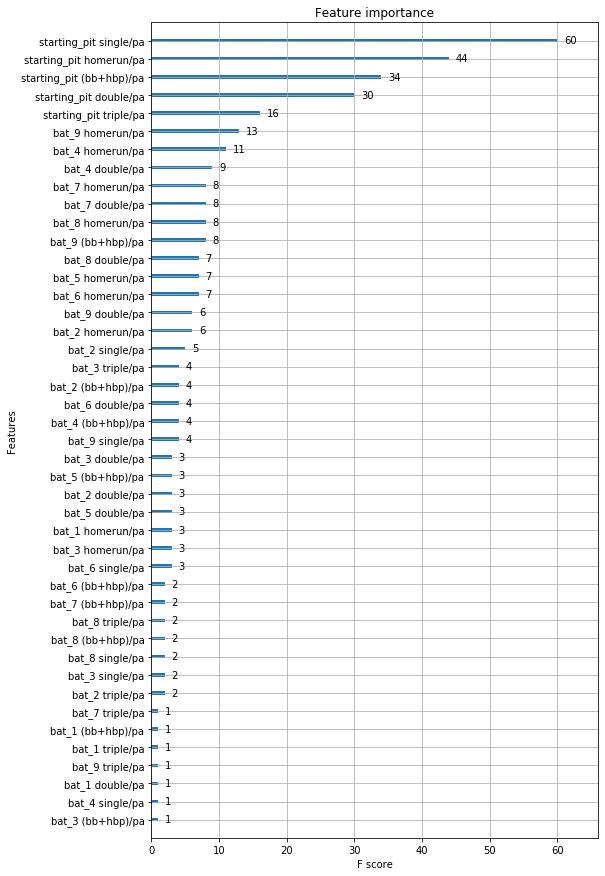

In [65]:
# Show feature importances.
xg_reg = xgb.train(params=params, dtrain=dmatrix, num_boost_round=50)
plt.rcParams["figure.figsize"] = (8, 15)
xgb.plot_importance(xg_reg)